# Noisy label detection for classification tasks from training loss dynamics statistics

[![Jupyter Notebook](https://img.shields.io/badge/jupyter-%23FA0F00.svg?style=for-the-badge&logo=jupyter&logoColor=white)](https://github.com/openvinotoolkit/datumaro/blob/develop/notebooks/10_noisy_label_detection_cls.ipynb)

This tutorial covers how to find noisy labeled samples in the training dataset while training the model on your dataset. This feature utilizes both [Datumaro](https://github.com/openvinotoolkit/datumaro) and [OpenVINO™ Training Extensions](https://github.com/openvinotoolkit/training_extensions) simultaneously.

## Prerequisite
### Prepare Imagenette2 dataset

Imagenette is a subset of 10 easily classified classes from Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute). For more detail, please see [fastai/imagenette Github repository](https://github.com/fastai/imagenette#imagenette-1).

In [ ]:
!curl https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz -o imagenette2.tgz
!tar -zxf imagenette2.tgz

### Install OpenVINO™ Training Extensions
For more details, please see this [OpenVINO™ Training Extensions installation guide](https://openvinotoolkit.github.io/training_extensions/latest/guide/get_started/quick_start_guide/installation.html).

In [ ]:
!pip install otx

## Synthesize noisy label using Datumaro Python API

In this section, we use the Datumaro Python API to synthesize noisy label samples. First import the `imagenette2` dataset. It then uses Datumaro's transform function to remap the label names to be more human-friendly and reindex the IDs from zero.

In [1]:
import datumaro as dm

dataset = dm.Dataset.import_from("imagenette2-320", "imagenet_with_subset_dirs")

mapping = {
    "n01440764": "tench",
    "n02102040": "English_springer",
    "n02979186": "cassette_player",
    "n03000684": "chain_saw",
    "n03028079": "church",
    "n03394916": "French_horn",
    "n03417042": "garbage_truck",
    "n03425413": "gas_pump",
    "n03445777": "golf_ball",
    "n03888257": "parachute",
}

dataset = dataset.transform("remap_labels", mapping=mapping)
dataset = dataset.transform("reindex")
dataset

Dataset
	size=13394
	source_path=imagenette2-320
	media_type=<class 'datumaro.components.media.Image'>
	annotated_items_count=13394
	annotations_count=13394
subsets
	train: # of items=9469, # of annotated items=9469, # of annotations=9469, annotation types=['label']
	val: # of items=3925, # of annotated items=3925, # of annotations=3925, annotation types=['label']
infos
	categories
	label: ['tench', 'English_springer', 'cassette_player', 'chain_saw', 'church', 'French_horn', 'garbage_truck', 'gas_pump', 'golf_ball', 'parachute']

We synthesize 0.2% of the training samples to have randomly noisy labels. After the synthesization, 12 training samples have noisy labels that are different from their original labels.

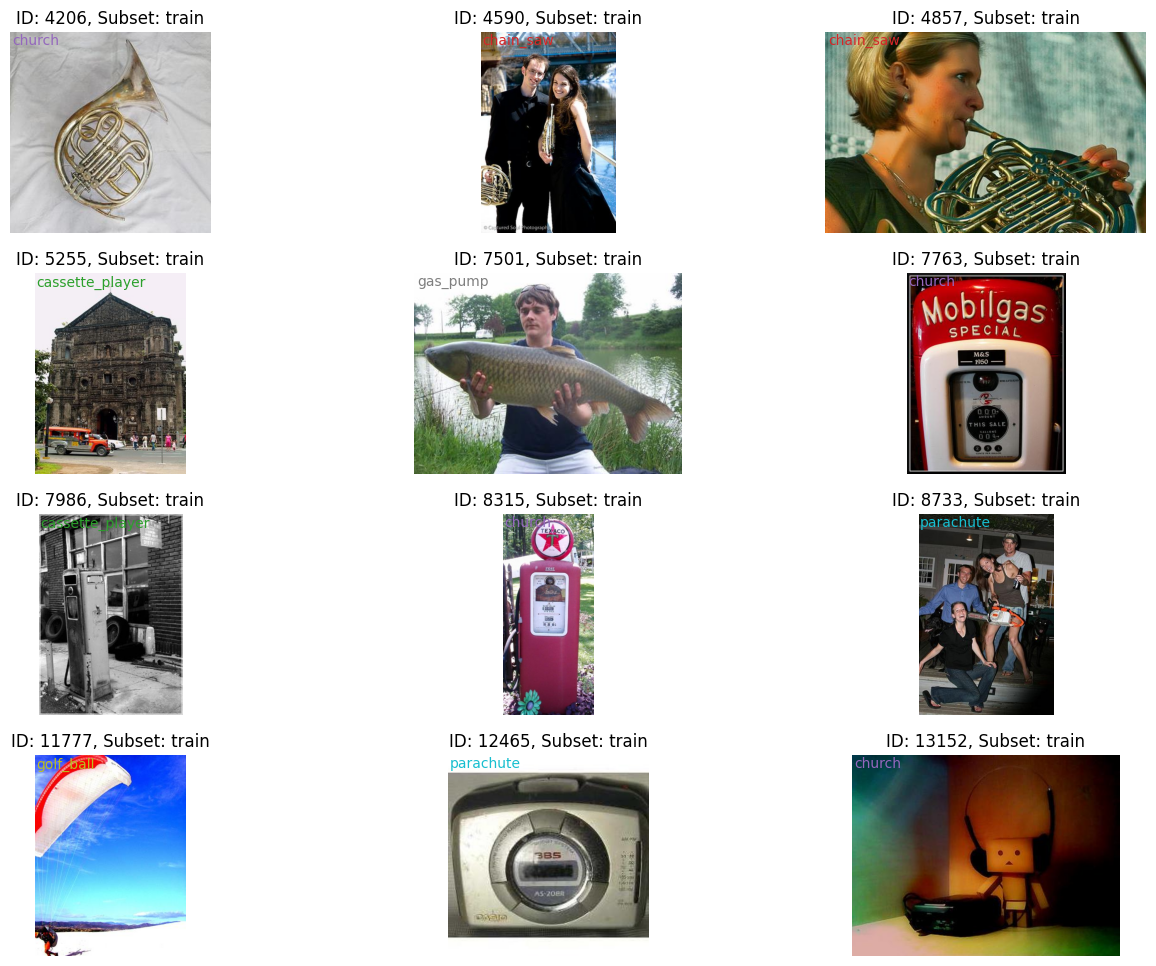

In [2]:
import random

random.seed(3003)

noise_rate = 0.002
true_noisy_ids = []
label_categories = dataset.categories()[dm.AnnotationType.label]
for item in dataset:
    if random.random() < noise_rate and item.subset == "train":
        true_noisy_ids += [item.id]

        for ann in item.annotations:
            new_label_id = random.choice(range(len(label_categories)))
            while new_label_id == ann.label:
                new_label_id = random.choice(range(len(label_categories)))

            ann.label = new_label_id

viz = dm.Visualizer(dataset, figsize=(16, 12))
fig = viz.vis_gallery(true_noisy_ids, "train")

We export this synthesized noisy label dataset to train the model with OpenVINO™ Training Extensions

In [ ]:
dataset.export("noisy-imagenette2-320", format="imagenet_with_subset_dirs", save_media=True)

## Train a model and export training loss dynamics statistics using OpenVINO™ Training Extensions

In this step, we train a classification model using OpenVINO™ Training Extensions. To see the detail guides for OpenVINO™ Training Extensions usage, please see [How-To-Train](https://openvinotoolkit.github.io/training_extensions/latest/guide/tutorials/base/how_to_train/classification.html). In this example, we use the CLI command to train the model. Adding the argument 'params --algo_backend.enable_noisy_label_detection True' at the end allows you to export training loss dynamics statistics at the end of training.

In [ ]:
!otx train Custom_Image_Classification_EfficinetNet-B0 \
    --train-data-roots noisy-imagenette2-320/train \
    --val-data-roots noisy-imagenette2-320/val \
    -o outputs \
    params --algo_backend.enable_noisy_label_detection True

## Import statistics and analyze them to find the noisy label samples

In this step, we import the statistics obtained during the model training to find the noisy label samples. Because we set the output directory as `outputs` in the previous step, we you can find the dataset including statistics which is exported to [Datumaro format](https://openvinotoolkit.github.io/datumaro/latest/docs/explanation/formats/datumaro) at `outputs/logs/noisy_label_detection`. To make training loss dynamics analysis easier, we provide an interface called `dm.LossDynamicsAnalyzer`. You can get the top-k candidates for noisy label samples using it. Additionally, we can also plot the exponential moving average (EMA) training loss curves of top-k candidates and compare them with the average of samples in the dataset. The EMA training loss is a very strong criterion for noisy label samples. For more detail, please see [1].

[1]: Zhou, Tianyi, Shengjie Wang, and Jeff Bilmes. "Robust curriculum learning: from clean label detection to noisy label self-correction." International Conference on Learning Representations. 2021.

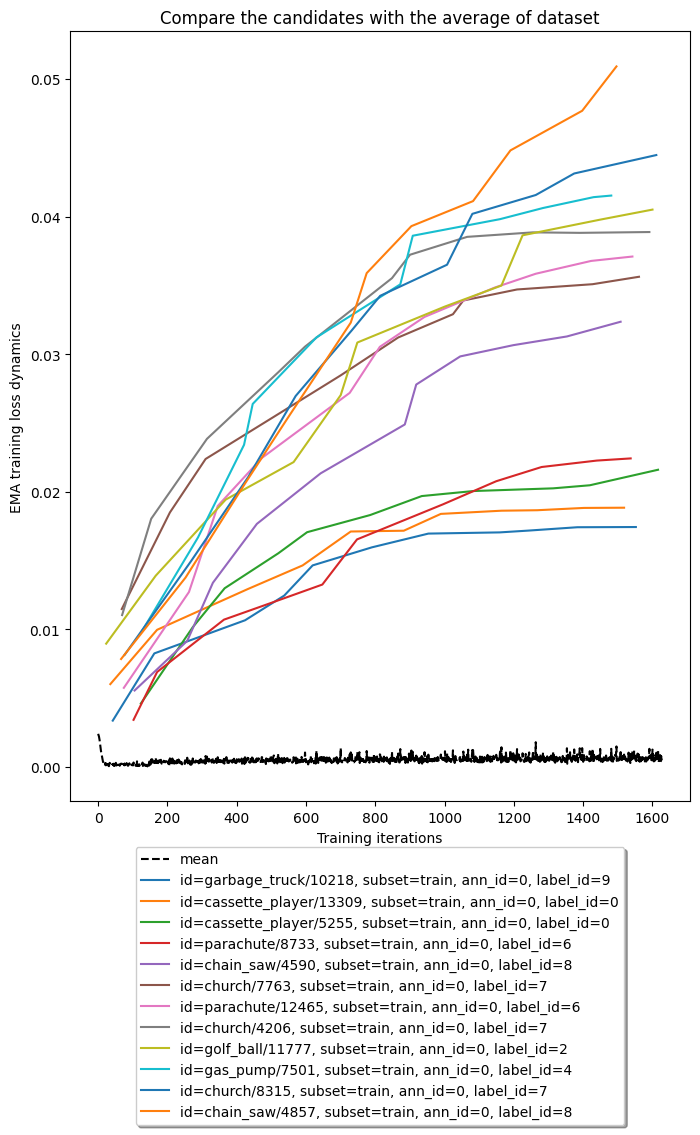

In [ ]:
# Import the exported statistics
stats = dm.Dataset.import_from("outputs/logs/noisy_label_detection", format="datumaro")
analyzer = dm.LossDynamicsAnalyzer(stats)

# Get top-k candidates
cands = analyzer.get_top_k_cands(12)

# Plot the top-k candidates EMA loss dynamics with the dataset average
fig = analyzer.plot_ema_loss_dynamics(cands, figsize=(8, 10), mode="mean")
fig.show()

To take a closer look at the noisy label candidates, we use `dm.Visualizer` to plot the images and labels in a gallery format. We can see there are many samples that we previously synthesized to have noisy labels.

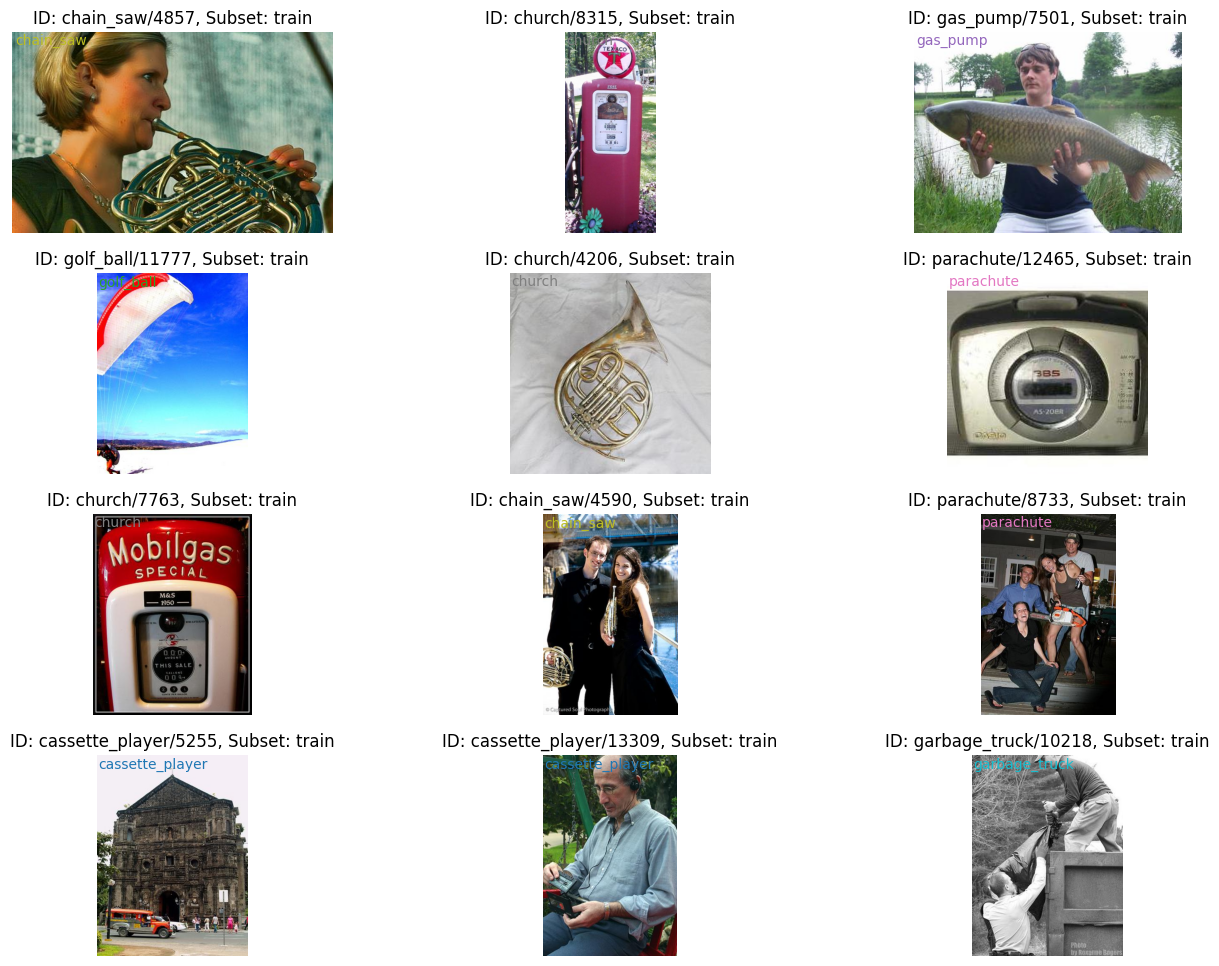

In [ ]:
viz = dm.Visualizer(stats, figsize=(16, 12))
fig = viz.vis_gallery([cand.id for cand in cands], "train")
fig.show()

In the last step, we calculate the quantitative scores for our noisy label detection algorithm. The accuracy and recall values for noisy label detection are obtained as follows.

In [ ]:
detect_noisy_ids = {cand.id.split(":")[-1] for cand in cands}
intersection = set(true_noisy_ids).intersection(detect_noisy_ids)

accuracy = 100.0 * len(intersection) / len(cands)
recall = 100.0 * len(intersection) / len(true_noisy_ids)

print(f"Accuracy = {accuracy:.1f}% and Recall = {recall:.1f}%")

Accuracy = 83.3% and Recall = 83.3%
